# LFV Higgs decays in SeeSaw model ( Thao et al results) 

## In this notebook we use the mpmath implementations of PaVe functions

In [1]:
from sympy import init_printing, Symbol,lambdify, symbols, Matrix
init_printing()
import OneLoopLFVHD as lfvhd

In [2]:
from seesaw_FF import TrianglesOneFermion, TrianglesTwoFermion, Bubbles,DiagramsOneFermionW, DiagramsOneFermionG
from seesaw_FF import g, mW, Uν, Uνc, mn, m, C, Cc, a,b,i,h
from seesaw_FF import j as jj

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from mpmath import *

In [5]:
mp.dps = 80; mp.pretty = True

In [6]:
import numpy as np

In [7]:
import subprocess as s

In [8]:
from multiprocessing import Pool
from time import time

In [9]:
def speedup_array(f,array,procs=4): 
    pool = Pool(procs,maxtasksperchild=100).map(f, array)
    result = np.array(list(pool))
    return result

## Numeric implementation of form factors

**Neutrino benchmark** is given by 

In [10]:
from OneLoopLFVHD.neutrinos import NuOscObservables
Nudata = NuOscObservables

In [11]:
m1 = mpf('1e-12')  #GeV 

#current values to Square mass differences
d21 = mpf(str(Nudata.squareDm21.central))*mpf('1e-18')# factor to convert eV^2 to GeV^2
d31 = mpf(str(Nudata.squareDm31.central))*mpf('1e-18')

#d21 = 7.5e-5*1e-18
#d31 = 2.457e-3*1e-18
m2 = sqrt(m1**2 + d21)
m3 = sqrt(m1**2 + d31)

m4 = lambda m6: m6/3
m5 = lambda m6: m6/2

### Form factor with one fermion in the loop.

#### AL one fermion 

In [12]:
from OneLoopLFVHD.data import ml

In [13]:
mh,ma,mb = symbols('m_h,m_a,m_b',real=True)
valores ={mW:mpf('80.379'),mh:mpf('125.10'),g:(2*mpf('80.379'))/mpf('246')}

cambios_hab = lambda a,b:{lfvhd.ma:valores[mh],lfvhd.mi:ml[a],lfvhd.mj:ml[b]}


Ubi, Ucai,mni = symbols('U_{bi}, {{U_{ai}^*}},m_{n_i}')
UnuOne = {mn[i]:mni,Uν[b,i]:Ubi,Uνc[a,i]:Ucai}

from Unu_seesaw import diagonalizationMnu
diagonalizationMnu1 = lambda m1,m6: diagonalizationMnu(
    m1,m2,m3,m6/mpf('3.0'),m6/mpf('2.0'),m6)

In [14]:
def GIM_One(exp):
    from sympy import Add
    args = exp.expand().args
    func = exp.expand().func
    if isinstance(func,Add):
        X = Add(*[t for t in args if t.has(mni)]).simplify()
    else:
        X = exp
    #X1 = X.collect([mni],evaluate=False)
    return X#mni**2*X1[mni**2]

In [15]:
def sumOne(m6,Aab,a,b): 
    mnk,Unu = diagonalizationMnu1(m1,m6)
    AL = []
    for k in range(1,7):
        A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))
        #print('Ai = ',A)
        AL.append(A)
    return mp.fsum(AL)


In [16]:
from OneLoopLFVHD.data import replaceBs, pave_functions

In [17]:
def numeric_sum_diagramsOne(a,b,quirality='L'):
    FdiagOneFer = []
    for Set in [TrianglesOneFermion,Bubbles]:#TrianglesOneFermion,Bubbles
        for dia in Set:
            if quirality=='L':
                x = dia.AL().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            elif quirality=='R':
                x = dia.AR().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            else:
                raise ValueError('quirality must be L or R')
            f = lambdify([mni,Ubi,Ucai],replaceBs(x),
                         modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'])
            #print(f(1,2,3))
            #fsum = lambda m6:sumOne(m6,f,a,b)
            FdiagOneFer.append(f)
    def suma(m6):
        out = []
        xs = []
        for g in FdiagOneFer:
            
            x = sumOne(m6,g,a,b)
            out.append(x)
            xs.append(x)
        return np.array(xs), mp.fsum(out)
    return suma

In [18]:
# #a = 2, b = 3
# ALOneTot23 = numeric_sum_diagramsOne(2,3,quirality='L')
# AROneTot23 = numeric_sum_diagramsOne(2,3,quirality='R')

# #a = 3, b = 2
# ALOneTot32 = numeric_sum_diagramsOne(3,2,quirality='L')
# AROneTot32 = numeric_sum_diagramsOne(3,2,quirality='R')

# #a = 1, b = 3
# ALOneTot13 = numeric_sum_diagramsOne(1,3,quirality='L')
# AROneTot13 = numeric_sum_diagramsOne(1,3,quirality='R')

# #a = 3, b = 1
# ALOneTot31 = numeric_sum_diagramsOne(3,1,quirality='L')
# AROneTot31 = numeric_sum_diagramsOne(3,1,quirality='R')

# #a = 1, b = 2
# ALOneTot12 = numeric_sum_diagramsOne(1,2,quirality='L')
# AROneTot12 = numeric_sum_diagramsOne(1,2,quirality='R')

# #a = 2, b = 1
# ALOneTot21 = numeric_sum_diagramsOne(2,1,quirality='L')
# AROneTot21 = numeric_sum_diagramsOne(2,1,quirality='R')

In [19]:
def ALOneTot23(m6):
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]
def AROneTot23(m6):
    return numeric_sum_diagramsOne(2,3,quirality='R')(m6)[1]

def ALOneTot32(m6):
    return numeric_sum_diagramsOne(3,2,quirality='L')(m6)[1]
def AROneTot32(m6):
    return numeric_sum_diagramsOne(3,2,quirality='R')(m6)[1]

def ALOneTot13(m6):
    return numeric_sum_diagramsOne(1,3,quirality='L')(m6)[1]
def AROneTot13(m6):
    return numeric_sum_diagramsOne(1,3,quirality='R')(m6)[1]

def ALOneTot31(m6):
    return numeric_sum_diagramsOne(3,1,quirality='L')(m6)[1]
def AROneTot31(m6):
    return numeric_sum_diagramsOne(3,1,quirality='R')(m6)[1]

def ALOneTot12(m6):
    return numeric_sum_diagramsOne(1,2,quirality='L')(m6)[1]
def AROneTot12(m6):
    return numeric_sum_diagramsOne(1,2,quirality='R')(m6)[1]

def ALOneTot21(m6):
    return numeric_sum_diagramsOne(2,1,quirality='L')(m6)[1]
def AROneTot21(m6):
    return numeric_sum_diagramsOne(2,1,quirality='R')(m6)[1]

In [20]:
ALOneTot23(1)

(0.0000000000000000000079568223861327197519474034299577482007467631633651049374180342441932108807796716 + 0.0j)

In [21]:
n = 200
expmp = linspace(-1,15,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

In [22]:
%%time
YLOne23 = speedup_array(ALOneTot23,m6np)
#YLOne32 = speedup_array(ALOneTot32,m6np)

YLOne13 = speedup_array(ALOneTot13,m6np)
#YLOne31 = speedup_array(ALOneTot31,m6np)

YLOne12 = speedup_array(ALOneTot12,m6np)
#YLOne21 = speedup_array(ALOneTot21,m6np)

Process ForkPoolWorker-4:


Process ForkPoolWorker-1:


Process ForkPoolWorker-3:


Traceback (most recent call last):


Process ForkPoolWorker-2:


Traceback (most recent call last):


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


Traceback (most recent call last):


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


Traceback (most recent call last):


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)


  File "<ipython-input-19-d396db124c5d>", line 2, in ALOneTot23
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))


  File "<ipython-input-17-af86e911b4f4>", line 21, in suma
    x = sumOne(m6,g,a,b)


  File "<ipython-input-19-d396db124c5d>", line 2, in ALOneTot23
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]


  File "<ipython-input-17-af86e911b4f4>", line 21, in suma
    x = sumOne(m6,g,a,b)


  File "<ipython-input-19-d396db124c5d>", line 2, in ALOneTot23
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]


  File "<ipython-input-15-86d824e0f061>", line 5, in sumOne
    A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))


  File "<ipython-input-17-af86e911b4f4>", line 21, in suma
    x = sumOne(m6,g,a,b)


  File "<lambdifygenerated-46>", line 2, in _lambdifygenerated
    return (mpf((0, 471452970272491923652901502724114691325594482658112906308462200793412828096597021, -266, 268))*(mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_0(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) - mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_1(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) + mpf((0, 685370762322471788586342628032753731725807578954286511567004741796763415369556275, -285, 269))*

  File "<ipython-input-15-86d824e0f061>", line 5, in sumOne
    A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/data.py", line 69, in <lambda>
    'C_2': lambda M0,M1,M2:C2(ma,mj,M0,M1,M2)


  File "<lambdifygenerated-46>", line 2, in _lambdifygenerated
    return (mpf((0, 471452970272491923652901502724114691325594482658112906308462200793412828096597021, -266, 268))*(mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_0(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) - mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_1(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) + mpf((0, 685370762322471788586342628032753731725807578954286511567004741796763415369556275, -285, 269))*

  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 156, in C2
    return ( (-1/ma**2)*(B2_0(mj,M0,M2) - B12_0(ma,M1,M2) + (M1**2-M0**2)*C0(ma,M0,M1,M2)))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 147, in C0
    return ((R0(y0,y1) + R0(y0,y2) - R0(y0,y3))/ma**2)#*(-1j*16)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/data.py", line 69, in <lambda>
    'C_2': lambda M0,M1,M2:C2(ma,mj,M0,M1,M2)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 26, in R0
    return Li2(x0/(x0-xi)) - Li2((x0-1.0)/(x0-xi))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 156, in C2
    return ( (-1/ma**2)*(B2_0(mj,M0,M2) - B12_0(ma,M1,M2) + (M1**2-M0**2)*C0(ma,M0,M1,M2)))


  File "/home/moiseszm/miniconda3/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 145, in C0
    y2 = x2(ma,M1,M2)


  File "<ipython-input-15-86d824e0f061>", line 5, in sumOne
    A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))


  File "<ipython-input-19-d396db124c5d>", line 2, in ALOneTot23
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]


  File "<lambdifygenerated-52>", line 2, in _lambdifygenerated
    return (mpf((0, 619878139641339069611579921750220823000071532473370500582362446338301049370035625, -274, 269))*(-mpf((0, 545270211513268124889783441958531805934829752162956088957147919235995172434735571, -280, 269))*Dummy_209*Dummy_210**2*Dummy_211*(C_0(Dummy_210, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) + C_1(Dummy_210, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)))) - mpf((0, 860772132886218123355963032791323628162323240449478054894441783451281977562336935, -279, 269))*Dummy_209*Dummy_211*(-2*C_1(Dummy_210, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258

  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 22, in Li2
    return polylog(2,x0)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/roots_mpmath2.py", line 82, in x2
    return mp.polyroots([a,b,c],extraprec=100)[1]#rootx2_estable(a,b,c)[1]


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/data.py", line 69, in <lambda>
    'C_2': lambda M0,M1,M2:C2(ma,mj,M0,M1,M2)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 1021, in f_wrapped
    retval = f(ctx, *args, **kwargs)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/calculus/polynomials.py", line 193, in polyroots
    roots[i] = p - x


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 156, in C2
    return ( (-1/ma**2)*(B2_0(mj,M0,M2) - B12_0(ma,M1,M2) + (M1**2-M0**2)*C0(ma,M0,M1,M2)))


  File "<ipython-input-17-af86e911b4f4>", line 21, in suma
    x = sumOne(m6,g,a,b)


  File "<ipython-input-15-86d824e0f061>", line 5, in sumOne
    A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 487, in __sub__
    v = new(cls)


  File "<lambdifygenerated-46>", line 2, in _lambdifygenerated
    return (mpf((0, 471452970272491923652901502724114691325594482658112906308462200793412828096597021, -266, 268))*(mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_0(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) - mpf((0, 217079669670244466794474553585799994898102141967610879043391102347029018996398789, -285, 267))*Dummy_191*Dummy_192**2*Dummy_193*C_1(Dummy_192, mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265)), mpf((0, 37229009363224953887804848816053301381351952389758091587710244579888197789313663, -258, 265))) + mpf((0, 685370762322471788586342628032753731725807578954286511567004741796763415369556275, -285, 269))*

  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/data.py", line 68, in <lambda>
    'C_1': lambda M0,M1,M2:C1(ma,mi,M0,M1,M2),


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 152, in C1
    return ((1/ma**2)*(B1_0(mi,M0,M1) - B12_0(ma,M1,M2) + (M2**2-M0**2)*C0(ma,M0,M1,M2)))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 484, in polylog
    return (-1)**(s+1)*polylog_series(ctx, s, 1/z) + polylog_continuation(ctx, s, z)


KeyboardInterrupt


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 26, in R0
    return Li2(x0/(x0-xi)) - Li2((x0-1.0)/(x0-xi))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 147, in C0
    return ((R0(y0,y1) + R0(y0,y2) - R0(y0,y3))/ma**2)#*(-1j*16)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 147, in C0
    return ((R0(y0,y1) + R0(y0,y2) - R0(y0,y3))/ma**2)#*(-1j*16)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 394, in polylog_series
    if abs(term) < tol:


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 409, in __abs__
    v._mpf_ = mpc_abs(s._mpc_, prec, rounding)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 26, in R0
    return Li2(x0/(x0-xi)) - Li2((x0-1.0)/(x0-xi))


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpc.py", line 121, in mpc_abs
    return mpf_hypot(a, b, prec, rnd)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 22, in Li2
    return polylog(2,x0)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 1401, in mpf_hypot
    hypot2 = mpf_add(mpf_mul(x,x), mpf_mul(y,y), prec+4)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 1021, in f_wrapped
    retval = f(ctx, *args, **kwargs)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 861, in gmpy_mpf_mul
    return (sign, man, sexp+texp, bc)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 484, in polylog
    return (-1)**(s+1)*polylog_series(ctx, s, 1/z) + polylog_continuation(ctx, s, z)


KeyboardInterrupt


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 394, in polylog_series
    if abs(term) < tol:


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpc.py", line 121, in mpc_abs
    return mpf_hypot(a, b, prec, rnd)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 409, in __abs__
    v._mpf_ = mpc_abs(s._mpc_, prec, rounding)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/OneLoopLFVHD/LFVHDFeynG_mpmath2.py", line 22, in Li2
    return polylog(2,x0)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 1402, in mpf_hypot
    return mpf_sqrt(hypot2, prec, rnd)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 1021, in f_wrapped
    retval = f(ctx, *args, **kwargs)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 1389, in mpf_sqrt
    man, rem = sqrtrem(man<<shift)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 484, in polylog
    return (-1)**(s+1)*polylog_series(ctx, s, 1/z) + polylog_continuation(ctx, s, z)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/functions/zeta.py", line 396, in polylog_series
    zk *= z


KeyboardInterrupt


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/ctx_mp_python.py", line 507, in __mul__
    v._mpc_ = mpc_mul(s._mpc_, t._mpc_, prec, rounding)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpc.py", line 158, in mpc_mul
    s = mpf_mul(b, c)


  File "/home/moiseszm/miniconda3/lib/python3.8/site-packages/mpmath/libmp/libmpf.py", line 855, in gmpy_mpf_mul
    man = sman*tman


KeyboardInterrupt


KeyboardInterrupt: 

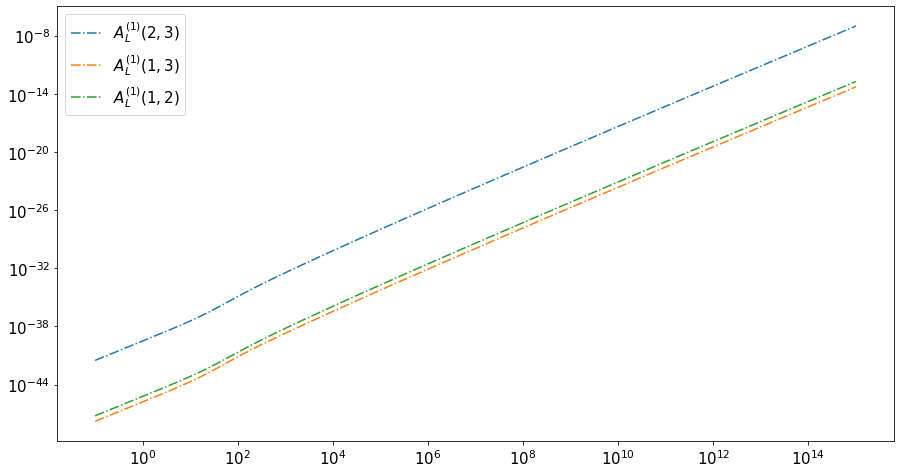

In [26]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(m6np),factor*abs(YLOne23)**2,'-.',label='$A_L^{(1)}(2,3)$')
#plt.loglog(np.real(m6np),factor*abs(YLOne32)**2,'--',label='$A_L^{(1)}(3,2)$')

plt.loglog(np.real(m6np),factor*abs(YLOne13)**2,'-.',label='$A_L^{(1)}(1,3)$')
#plt.loglog(np.real(m6np),factor*abs(YLOne31)**2,'--',label='$A_L^{(1)}(3,1)$')

plt.loglog(np.real(m6np),factor*abs(YLOne12)**2,'-.',label='$A_L^{(1)}(1,2)$')
#plt.loglog(np.real(m6np),factor*abs(YLOne21)**2,'--',label='$A_L^{(1)}(2,1)$')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

### Form factor with two fermion in the loop.

In [27]:
mnj = symbols('m_{n_j}',positive=True)
Cijs, Cijcs, Ubj = symbols('C_{ij}, {{C_{ij}^*}},U_{bj}')
UnuTwo = {mn[i]:mni,mn[jj]:mnj,C[i,jj]:Cijs, Cc[i,jj]:Cijcs, Uν[b,jj]:Ubj, Uνc[a,i]:Ucai}
UnuTwo

In [28]:
fsL = lambda k,a,b:TrianglesTwoFermion[k].AL().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)
fsR = lambda k,a,b:TrianglesTwoFermion[k].AR().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)

In [29]:
fL = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsL(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )
fR = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsR(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )

In [30]:
fL(0,2,3)(1,2,3,4,5,6)

(-0.00000027247998590854213844099384583421238032773286440032857894900089991919247803179895 + 0.00000016352018180926886301424865222343006675260280399774946471613918548438945707843168j)

In [31]:
def sumatwo(mm6,k,a,b,quirality='L'):
    xs = []
    if quirality=='L':
        g = fL(k,a,b)
    elif quirality=='R':
        g = fR(k,a,b)
    else:
        raise ValueError('quirality must be L or R')
        
    mnk,Unu = diagonalizationMnu1(m1,mm6)
    Cij = lambda i,j: mp.fsum([Unu[c,i]*conj(Unu[c,j]) for c in range(3)])
    for p in range(1,7):
        for q in range(1,7):
            x = g(mnk[p-1],mnk[q-1],Unu[b-1,q-1],conj(Unu[a-1,p-1]),Cij(p-1,q-1),conj(Cij(p-1,q-1)))
            xs.append(x)
            #print(f'i = {p} and j = {q}')
            #print(f'|f| = {x}')
    return mp.fsum(xs)

In [35]:
def totaltwo(m6,a,b,quirality='L'):
    return sumatwo(m6,0,a,b,quirality) + sumatwo(m6,1,a,b,quirality)

In [36]:
ALTwoTot23 = lambda m6: totaltwo(m6,2,3,'L')
ARTwoTot23 = lambda m6: totaltwo(m6,2,3,'R')

ALTwoTot32 = lambda m6: totaltwo(m6,3,2,'L')
ARTwoTot32 = lambda m6: totaltwo(m6,3,2,'R')

ALTwoTot13 = lambda m6: totaltwo(m6,1,3,'L')
ARTwoTot13 = lambda m6: totaltwo(m6,1,3,'R')

ALTwoTot31 = lambda m6: totaltwo(m6,3,1,'L')
ARTwoTot31 = lambda m6: totaltwo(m6,3,1,'R')

ALTwoTot12 = lambda m6: totaltwo(m6,1,2,'L')
ARTwoTot12 = lambda m6: totaltwo(m6,1,2,'R')

ALTwoTot21 = lambda m6: totaltwo(m6,2,1,'L')
ARTwoTot21 = lambda m6: totaltwo(m6,2,1,'R')

In [37]:
abs(ALTwoTot23(m6np[-1])),abs(sumatwo(m6np[-1],0,2,3,'L')+ sumatwo(m6np[-1],1,2,3,'L'))

(0.00014030508912878032175609972422292510197134847998752268035889621834190915992304946,
 0.00014030508912878032175609972422292510197134847998752268035889621834190915992304946)

## Total Form Factors

In [38]:
#a = 2, b = 3
def ALtot23(m6):
    return  ALOneTot23(m6) + ALTwoTot23(m6)
def ARtot23(m6):
    return  AROneTot23(m6) + ARTwoTot23(m6)

#a = 3, b = 2
def ALtot32(m6):
    return  ALOneTot32(m6) + ALTwoTot32(m6)
def ARtot32(m6):
    return  AROneTot32(m6) + ARTwoTot32(m6)

#a = 1, b = 3
def ALtot13(m6):
    return  ALOneTot13(m6) + ALTwoTot13(m6)
def ARtot13(m6):
    return  AROneTot13(m6) + ARTwoTot13(m6)

#a = 3, b = 1
def ALtot31(m6):
    return  ALOneTot31(m6) + ALTwoTot31(m6)
def ARtot31(m6):
    return  AROneTot31(m6) + ARTwoTot31(m6)

#a = 1, b = 2
def ALtot12(m6):
    return  ALOneTot12(m6) + ALTwoTot12(m6)
def ARtot12(m6):
    return  AROneTot12(m6) + ARTwoTot12(m6)

#a = 2, b = 1
def ALtot21(m6):
    return  ALOneTot21(m6) + ALTwoTot21(m6)
def ARtot21(m6):
    return  AROneTot21(m6) + ARTwoTot21(m6)

## Width decay of $h \to e_a e_b$

In [39]:
from OneLoopLFVHD import Γhlilj

In [40]:
def Γhl2l3(m6):
    return Γhlilj(ALtot23(m6),ARtot23(m6),valores[mh],ml[2],ml[3])
def Γhl3l2(m6):
    return Γhlilj(ALtot32(m6),ARtot32(m6),valores[mh],ml[3],ml[2])

def Γhl1l3(m6):
    return Γhlilj(ALtot13(m6),ARtot13(m6),valores[mh],ml[1],ml[3])
def Γhl3l1(m6):
    return Γhlilj(ALtot31(m6),ARtot31(m6),valores[mh],ml[3],ml[1])

def Γhl1l2(m6):
    return Γhlilj(ALtot12(m6),ARtot12(m6),valores[mh],ml[1],ml[2])
def Γhl2l1(m6):
    return Γhlilj(ALtot21(m6),ARtot21(m6),valores[mh],ml[2],ml[1])

In [41]:
n = 800
expmp = linspace(-1,15,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

In [42]:
%%time
YW23 = speedup_array(Γhl2l3,m6np)
#YW32 = speedup_array(Γhl3l2,m6np)

YW13 = speedup_array(Γhl1l3,m6np)
#YW31 = speedup_array(Γhl3l1,m6np)

YW12 = speedup_array(Γhl1l2,m6np)

#YW21 = speedup_array(Γhl2l1,m6np)

CPU times: user 451 ms, sys: 282 ms, total: 732 ms
Wall time: 3min 35s


In [43]:
Wtot = YW23 + YW13 + YW12 + 0.0032# + YW32 + YW31 + YW21

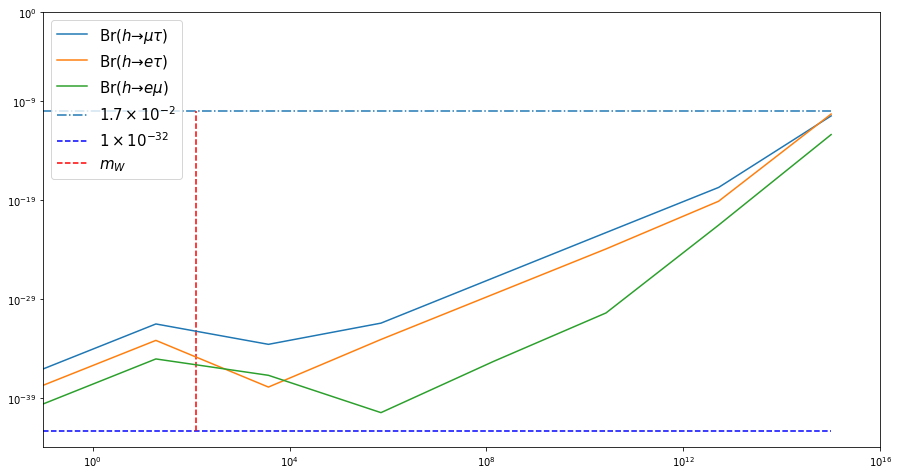

In [44]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(m6np),(YW23 #+ YW32
                         )/Wtot,label=r'Br($h \to \mu \tau$)')
plt.loglog(np.real(m6np),(YW13 #+ YW31
                         )/Wtot,label=r'Br($h \to e \tau$)')
plt.loglog(np.real(m6np),(YW12 #+ YW21
                         )/Wtot,label=r'Br($h \to e \mu$)')

#xx = ((YW23 + YW32)/Wtot)[-1]
plt.hlines(1e-10,0.1,1e15,linestyles='-.',label=r'$1.7\times 10^{-2}$')
plt.hlines(5e-43,0.1,1e15,linestyles='--',color='b',label=r'$1\times 10^{-32}$')
plt.vlines(125.1,5e-43,1e-10,linestyles='--',color='r',label=r'$m_W$')
plt.xlim(1e-1,1e15)
plt.yticks([1e-39,1e-29,1e-19,1e-9,1])
plt.xticks([1,1e4,1e8,1e12,1e16])

plt.legend(fontsize=15)

In [37]:
import pandas as pd

In [38]:
df = pd.DataFrame({'m6':m6np,
                   'Whl2l3':YW23,
                   #'Whl3l2':YW32,
                   'Whl1l3':YW13,
                   #'Whl3l1':YW31,
                   'Whl1l2':YW12})
                   #'Whl2l1':YW21})

In [39]:
df.to_csv('LFVHD-3.txt',sep='\t')

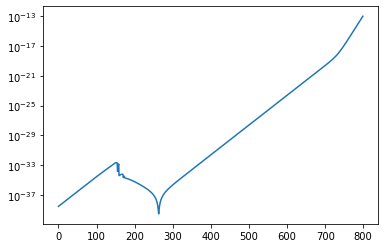

In [40]:
plt.semilogy(np.array(list(map(mpf,df['Whl2l3']))))